In [1]:
#!jupyter nbconvert --to script 1-preprocessing.ipynb

In [2]:
from collections import defaultdict
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

pd.set_option('display.max_columns', None)

In [3]:
drop_initially = ['pais_residencia', 'fecha_alta', 'ult_fec_cli_1t', 'conyuemp',
                  'canal_entrada', 'indfall', 'tipodom', 'nomprov']

In [4]:
import warnings

# Disable typecast warnings
warnings.filterwarnings('ignore')

na_values=['NA', 'nan']

dtype = {'tiprel_1mes':np.str, 'indrel_1mes':np.str, 'fecha_dato':np.str, 'ult_fec_cli_1t':np.str}

iter_csv = pd.read_csv('../data/raw/train.csv.zip', na_values = na_values, skipinitialspace = True, 
                       iterator=True, chunksize=100000, dtype=dtype)

df = pd.concat([chunk for chunk in iter_csv], ignore_index=True)
df.drop(drop_initially, axis=1, inplace=True)

In [5]:
df.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,H,35.0,0.0,6.0,1.0,1.0,A,S,N,29.0,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,V,23.0,0.0,35.0,1.0,1,I,S,S,13.0,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,V,23.0,0.0,35.0,1.0,1,I,S,N,13.0,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,H,22.0,0.0,35.0,1.0,1,I,S,N,50.0,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,V,23.0,0.0,35.0,1.0,1,A,S,N,50.0,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [6]:
na_values=['NA', 'nan']
dtype = {'tiprel_1mes':np.str, 'indrel_1mes':np.str, 'fecha_dato':np.str}

iter_csv = pd.read_csv('../data/raw/test.csv.zip', na_values = na_values, skipinitialspace = True, 
                       iterator=True, chunksize=100000, dtype=dtype)

test = pd.concat([chunk for chunk in iter_csv], ignore_index=True)
test.drop(drop_initially, axis=1, inplace=True)

In [7]:
test.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,F,V,56,0,256,1,1,A,S,N,28.0,1,326124.90,01 - TOP
1,2016-06-28,1170544,N,H,36,0,34,1,1,I,S,N,3.0,0,NaN,02 - PARTICULARES
2,2016-06-28,1170545,N,V,22,0,34,1,1,A,S,N,15.0,1,NaN,03 - UNIVERSITARIO
3,2016-06-28,1170547,N,H,22,0,34,1,1,I,S,N,8.0,0,148402.98,03 - UNIVERSITARIO
4,2016-06-28,1170548,N,H,22,0,34,1,1,I,S,N,7.0,0,106885.80,03 - UNIVERSITARIO


In [8]:
products = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
            'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
            'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
            'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
            'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
            'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
            'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
            'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

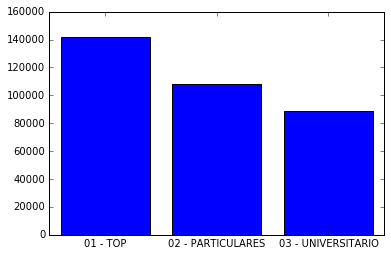

In [9]:
segm_rent = defaultdict(set)
df.groupby(['segmento']).apply(lambda x: segm_rent[x.segmento.values[0]].add(x.renta.median()))

keys = []
vals = []

for k, v in segm_rent.items():
    keys.append(k)
    vals.append(list(v)[0])
    
fig, ax = plt.subplots()
ind = np.arange(len(keys))  # the x locations for the groups

ax.bar(ind, vals, align='center')
ax.set_xticks(ind)
ax.set_xticklabels(keys)
plt.show()

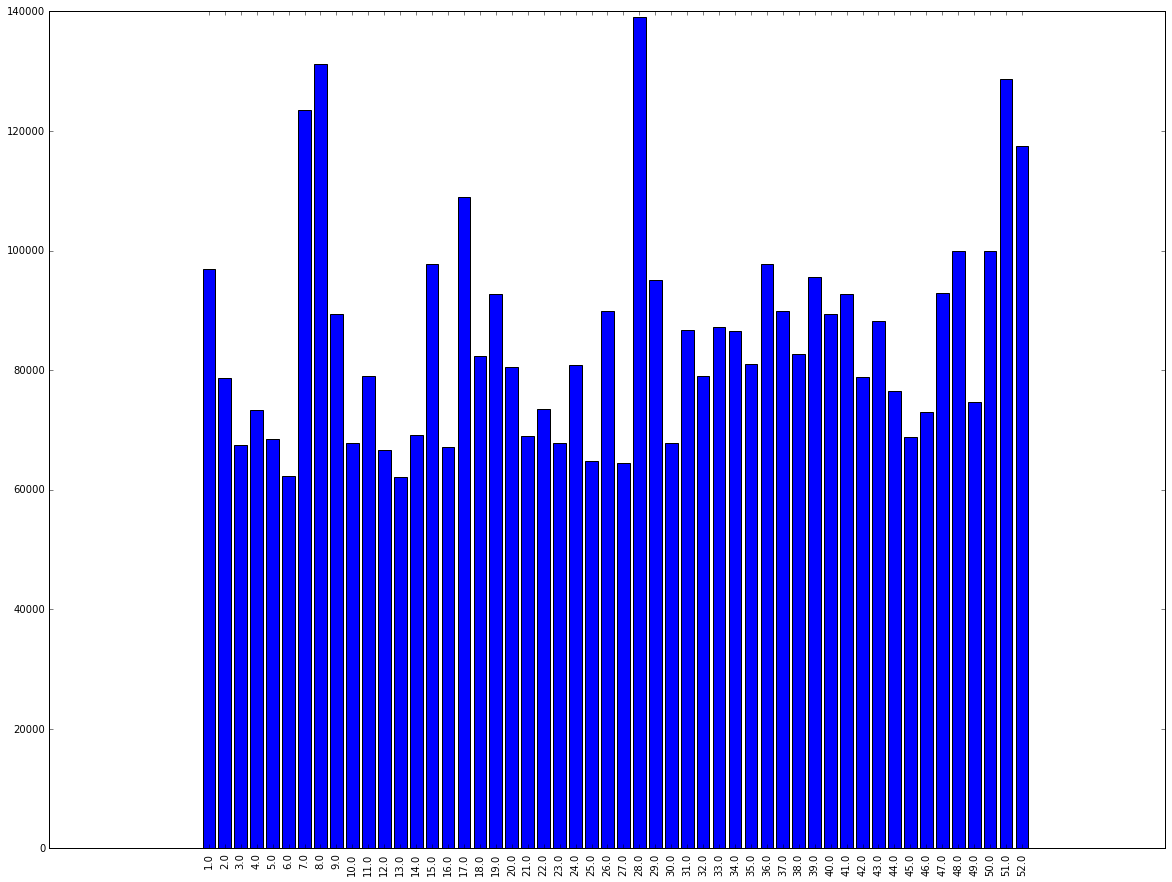

In [10]:
prov_rent = defaultdict(set)
df.groupby(['cod_prov']).apply(lambda x: prov_rent[x.cod_prov.values[0]].add(x.renta.median()))

keys = []
vals = []

for k, v in prov_rent.items():
    keys.append(k)
    vals.append(list(v)[0])
    
fig, ax = plt.subplots(figsize=(20, 15))
ind = np.arange(len(keys))  # the x locations for the groups

ax.bar(ind, vals, align='center')
ax.set_xticks(ind)
ax.set_xticklabels(keys, rotation='vertical')
plt.show()

In [11]:
grouped = df.groupby(["cod_prov", "segmento"]).agg({"renta":lambda x: x.median(skipna=True)})

In [12]:
grouped.head()

renta
cod_prov segmento                     
1.0      01 - TOP             55271.07
         02 - PARTICULARES   164007.12
         03 - UNIVERSITARIO   74453.79
2.0      01 - TOP             88457.49
         02 - PARTICULARES    81777.15

In [13]:
for (prov, segm) in grouped.index.get_values():
    df.ix[(df.renta.isnull()) & (df.cod_prov == prov) & (df.segmento == segm), 'renta'] = grouped.loc[prov, segm].values[0]
    df.ix[(df.renta.isnull()) & (df.cod_prov == prov), 'renta'] = grouped.renta.loc[prov, :].mean()
    df.ix[(df.renta.isnull()) & (df.segmento == segm), 'renta'] = grouped.renta.loc[grouped.index.get_level_values('segmento') == segm].mean()
    
    
    test.ix[(test.renta.isnull()) & (test.cod_prov == prov) & (test.segmento == segm), 'renta'] = grouped.loc[prov, segm].values[0]
    test.ix[(test.renta.isnull()) & (test.cod_prov == prov), 'renta'] = grouped.renta.loc[prov, :].mean()
    test.ix[(test.renta.isnull()) & (test.segmento == segm), 'renta'] = grouped.renta.loc[grouped.index.get_level_values('segmento') == segm].mean()
    
df.loc[df.renta.isnull(), 'renta'] = df.renta.median()
test.loc[test.renta.isnull(), 'renta'] = df.renta.median()

In [14]:
renta_lower = df.groupby(["cod_prov", "segmento"]).agg({"renta":lambda x: x.quantile(0.33)})
renta_upper = df.groupby(["cod_prov", "segmento"]).agg({"renta":lambda x: x.quantile(0.66)})
renta_quantiles = renta_lower.join(renta_upper, lsuffix='_lower', rsuffix='_upper')
del renta_lower, renta_upper

In [15]:
renta_quantiles.head()

renta_lower    renta_upper
cod_prov segmento                                      
1.0      01 - TOP               55271.07   55271.070000
         02 - PARTICULARES      97910.66   97910.660000
         03 - UNIVERSITARIO     97910.66   97910.660000
2.0      01 - TOP               74481.18  102241.675294
         02 - PARTICULARES      71999.64   91295.700000

In [16]:
df = df[df.age.notnull() & df.sexo.notnull() & df.fecha_dato.isin(['2015-05-28', '2015-06-28', '2016-05-28', '2016-06-28'])]
df.sort_values(['ncodpers', 'fecha_dato'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [17]:
df.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-05-28,15889,F,V,56.0,0.0,245.0,1.0,1,A,S,N,28.0,1.0,326124.9,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
1,2015-06-28,15889,F,V,56.0,0.0,245.0,1.0,1,A,S,N,28.0,1.0,326124.9,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
2,2016-05-28,15889,F,V,56.0,0.0,255.0,1.0,1,A,S,N,28.0,1.0,326124.9,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
3,2015-05-28,15890,A,V,62.0,0.0,246.0,1.0,1,A,S,N,28.0,1.0,71461.2,02 - PARTICULARES,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1
4,2015-06-28,15890,A,V,62.0,0.0,246.0,1.0,1,A,S,N,28.0,1.0,71461.2,02 - PARTICULARES,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1


In [18]:
for idx, row in renta_quantiles.iterrows():
    result = df.loc[(df.cod_prov == idx[0]) & (df.segmento == idx[1]), 'renta'].apply(lambda x: 0 if x<=row[0] else 1 if x<=row[1] else 2)
    df.loc[(df.cod_prov == idx[0]) & (df.segmento == idx[1]), 'renta'] = result

result = df.age.apply(lambda x: 0 if x<25 else 1 if x<31 else 2 if x<41 else 3 if x<61 else 4)
df.age = result

In [19]:
df.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-05-28,15889,F,V,3,0.0,245.0,1.0,1,A,S,N,28.0,1.0,2.0,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
1,2015-06-28,15889,F,V,3,0.0,245.0,1.0,1,A,S,N,28.0,1.0,2.0,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
2,2016-05-28,15889,F,V,3,0.0,255.0,1.0,1,A,S,N,28.0,1.0,2.0,01 - TOP,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0
3,2015-05-28,15890,A,V,4,0.0,246.0,1.0,1,A,S,N,28.0,1.0,0.0,02 - PARTICULARES,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1
4,2015-06-28,15890,A,V,4,0.0,246.0,1.0,1,A,S,N,28.0,1.0,0.0,02 - PARTICULARES,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1


In [20]:
for idx, row in renta_quantiles.iterrows():
    result = test.loc[(test.cod_prov == idx[0]) & (test.segmento == idx[1]), 'renta'].apply(lambda x: 0 if x<=row[0] else 1 if x<=row[1] else 2)
    test.loc[(test.cod_prov == idx[0]) & (test.segmento == idx[1]), 'renta'] = result
    
result = test.age.apply(lambda x: 0 if x<25 else 1 if x<31 else 2 if x<41 else 3 if x<61 else 4)
test.age = result

In [21]:
test.head()

,fecha_dato,ncodpers,ind_empleado,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,cod_prov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,F,V,3,0,256,1,1,A,S,N,28.0,1,2.0,01 - TOP
1,2016-06-28,1170544,N,H,2,0,34,1,1,I,S,N,3.0,0,1.0,02 - PARTICULARES
2,2016-06-28,1170545,N,V,0,0,34,1,1,A,S,N,15.0,1,0.0,03 - UNIVERSITARIO
3,2016-06-28,1170547,N,H,0,0,34,1,1,I,S,N,8.0,0,2.0,03 - UNIVERSITARIO
4,2016-06-28,1170548,N,H,0,0,34,1,1,I,S,N,7.0,0,2.0,03 - UNIVERSITARIO


In [22]:
def sub_code_and_toint(text):
    return 0.0 if pd.isnull(text) else float(str(text)[1:2])
    
def preprocess_features(X):        
    dummies = ['ind_empleado', 'indrel_1mes', 'indrel_1mes', 'tiprel_1mes', 'segmento']

    # sexo
    X.sexo.replace(to_replace=['V', 'H'], value=[1.0, 0.0], inplace=True)
    
    # ind_empleado
    ind_empleado = pd.get_dummies(X.ind_empleado, prefix = 'ind_empleado')
    X = pd.concat([X, ind_empleado], axis=1)
    
    # ind_nuevo
    X.ix[(X.ind_nuevo.isnull()) & (X.antiguedad.isnull()), 'ind_nuevo'] = 0
    X.ix[(X.ind_nuevo.isnull()) & (X.antiguedad < 6), 'ind_nuevo'] = 1
    X.ix[(X.ind_nuevo.isnull()) & (X.antiguedad >= 6), 'ind_nuevo'] = 0    
    
    # indrel
    X.indrel.replace(to_replace=[99.], value=[0.], inplace=True)
    
    # indrel_1mes
    X.indrel_1mes.replace(to_replace=['P', float('nan')], value=[5., 6.], inplace=True)
    X.indrel_1mes = X.indrel_1mes.astype(np.float16)
    indrel_1mes = pd.get_dummies(X.indrel_1mes, prefix = 'indrel_1mes')
    X = pd.concat([X, indrel_1mes], axis=1)   
    
    # tiprel_1mes
    X.tiprel_1mes.replace(to_replace=[float('nan')], value=['N'], inplace=True)
    tiprel_1mes = pd.get_dummies(X.tiprel_1mes, prefix = 'tiprel_1mes')
    X = pd.concat([X, tiprel_1mes], axis=1)   
    
    # indresi
    X.indresi.replace(to_replace=['S', 'N'], value=[1.0, 0.0], inplace=True) 
    
    # indext
    X.indext.replace(to_replace=['S', 'N'], value=[1.0, 0.0], inplace=True) 
    
    # cod_prov
    X.cod_prov.replace(to_replace=[float('nan')], value=[0.], inplace=True)

    # segmento
    segmento = pd.get_dummies(X.segmento, prefix = 'segmento')
    X = pd.concat([X, segmento], axis=1)  
    
    X.drop(dummies, axis=1, inplace=True)   
        
    return X

In [23]:
df = preprocess_features(df)
df.loc[df.ind_nomina_ult1.isnull(), 'ind_nomina_ult1'] = 0 
df.loc[df.ind_nom_pens_ult1.isnull(), 'ind_nom_pens_ult1'] = 0

test = preprocess_features(test)
test.loc[test.sexo.isnull(), 'sexo'] = 0

In [24]:
df.head()

,fecha_dato,ncodpers,sexo,age,ind_nuevo,antiguedad,indrel,indresi,indext,cod_prov,ind_actividad_cliente,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,ind_empleado_A,ind_empleado_B,ind_empleado_F,ind_empleado_N,ind_empleado_S,indrel_1mes_1.0,indrel_1mes_2.0,indrel_1mes_3.0,indrel_1mes_4.0,indrel_1mes_5.0,indrel_1mes_6.0,tiprel_1mes_A,tiprel_1mes_I,tiprel_1mes_N,tiprel_1mes_P,tiprel_1mes_R,segmento_01 - TOP,segmento_02 - PARTICULARES,segmento_03 - UNIVERSITARIO
0,2015-05-28,15889,1.0,3,0.0,245.0,1.0,1.0,0.0,28.0,1.0,2.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
1,2015-06-28,15889,1.0,3,0.0,245.0,1.0,1.0,0.0,28.0,1.0,2.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
2,2016-05-28,15889,1.0,3,0.0,255.0,1.0,1.0,0.0,28.0,1.0,2.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
3,2015-05-28,15890,1.0,4,0.0,246.0,1.0,1.0,0.0,28.0,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2015-06-28,15890,1.0,4,0.0,246.0,1.0,1.0,0.0,28.0,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1.0,1.0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0


In [25]:
test.head()

,fecha_dato,ncodpers,sexo,age,ind_nuevo,antiguedad,indrel,indresi,indext,cod_prov,ind_actividad_cliente,renta,ind_empleado_A,ind_empleado_B,ind_empleado_F,ind_empleado_N,ind_empleado_S,indrel_1mes_1.0,indrel_1mes_3.0,indrel_1mes_6.0,tiprel_1mes_A,tiprel_1mes_I,tiprel_1mes_N,tiprel_1mes_P,segmento_01 - TOP,segmento_02 - PARTICULARES,segmento_03 - UNIVERSITARIO
0,2016-06-28,15889,1.0,3,0,256,1,1.0,0.0,28.0,1,2.0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0
1,2016-06-28,1170544,0.0,2,0,34,1,1.0,0.0,3.0,0,1.0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
2,2016-06-28,1170545,1.0,0,0,34,1,1.0,0.0,15.0,1,0.0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1
3,2016-06-28,1170547,0.0,0,0,34,1,1.0,0.0,8.0,0,2.0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
4,2016-06-28,1170548,0.0,0,0,34,1,1.0,0.0,7.0,0,2.0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1


In [26]:
df.to_csv('../data/processed/train-processed.csv.gz', index=False, compression='gzip')

In [27]:
test.to_csv('../data/processed/test-processed.csv.gz', index=False, compression='gzip')